In [824]:
import numpy as np
import os

from utils import set_params
from utils import load_pickle, extract_used_data
from utils import mergeAB, align_track, z_score_on
from utils import pca_fit, umap_fit

from utils.config import Params
from typing import Any, Dict, List
import matplotlib.pyplot as plt
import math

In [825]:

def get_data(file_path: str, params: Params) -> Dict[str, Any]:
    data = load_pickle(file_path)
    data = extract_used_data(data)
    mergeAB(data)
    align_track(data, params)
    z_score_on(data, params, ana_tt=['origin'], ana_bt=['*'])
    z_score_on(data, params, ana_tt=['pattern_*'], ana_bt=['*'])
    z_score_on(data, params, ana_tt=['position_*'], ana_bt=['*'])
    return data


In [826]:

def local_poly_velocity(traj: np.ndarray, window_size, order, dt: float = 1.0) -> np.ndarray:
    """
    traj: (dim, time)
    window_size: odd number, number of points used in local fit
    order: polynomial order (>=1). e.g., 3=cubic, 5=quintic
    dt: time step (default 1.0)

    return:
        vel: (dim, time), local tangent (derivative) at the center of each window
    """
    traj = np.asarray(traj, dtype=float)
    if traj.ndim != 2:
        raise ValueError("traj must be 2D array with shape (dim, time)")
    dim, T = traj.shape

    W = int(window_size)
    p = int(order)
    if W % 2 != 1 or W < 3:
        raise ValueError("window_size must be an odd integer >= 3")
    if p < 1:
        raise ValueError("order must be >= 1")
    if p >= W:
        raise ValueError("order must be < window_size (otherwise underdetermined)")
    if dt <= 0:
        raise ValueError("dt must be > 0")

    m = W // 2
    # centered integer grid: tau = -m,...,0,...,m  (dimensionless)
    tau = np.arange(-m, m + 1, dtype=float)

    # Vandermonde for polynomial fit: [1, tau, tau^2, ...]
    V = np.vander(tau, N=p + 1, increasing=True)  # (W, p+1)

    # Map from window samples y (length W) -> polynomial coeffs a (length p+1)
    # a = pinv(V) @ y
    pinvV = np.linalg.pinv(V)  # (p+1, W)

    # derivative wrt tau at center (tau=0) is a1
    w = pinvV[1, :]  # (W,) weights to get dy/dtau at center

    # Convert to dy/dt: dy/dt = (dy/dtau) / dt
    w = w / dt

    # pad time axis for same-length output
    # reflect padding tends to behave nicely for smooth trajectories
    padded = np.pad(traj, pad_width=((0, 0), (m, m)), mode="edge")  # (dim, T+2m)

    vel = np.empty((dim, T), dtype=float)
    # sliding dot: vel[:, t] = sum_k w[k] * traj[:, t+k-m]
    for t in range(T):
        vel[:, t] = padded[:, t:t + W] @ w  # (dim,)

    return vel


In [827]:
# from turtle import color
# import numpy as np
# import plotly.graph_objects as go

# def local_poly_velocity(traj: np.ndarray, window_size, order, dt: float = 1.0) -> np.ndarray:
#     traj = np.asarray(traj, dtype=float)
#     if traj.ndim != 2:
#         raise ValueError("traj must be 2D array with shape (dim, time)")
#     dim, T = traj.shape

#     W = int(window_size)
#     p = int(order)
#     if W % 2 != 1 or W < 3:
#         raise ValueError("window_size must be an odd integer >= 3")
#     if p < 1:
#         raise ValueError("order must be >= 1")
#     if p >= W:
#         raise ValueError("order must be < window_size (otherwise underdetermined)")
#     if dt <= 0:
#         raise ValueError("dt must be > 0")

#     m = W // 2
#     tau = np.arange(-m, m + 1, dtype=float)
#     V = np.vander(tau, N=p + 1, increasing=True)  # (W, p+1)
#     pinvV = np.linalg.pinv(V)                     # (p+1, W)

#     w = pinvV[1, :] / dt  # dy/dt weights

#     padded = np.pad(traj, pad_width=((0, 0), (m, m)), mode="edge")
#     vel = np.empty((dim, T), dtype=float)
#     for t in range(T):
#         vel[:, t] = padded[:, t:t + W] @ w
#     return vel

# # ========== 1) 生成更复杂、方向随机变化的 3D 轨迹（解析可导） ==========
# np.random.seed(42)

# T = 2000
# dt = 0.01
# t = np.arange(T) * dt

# K = 18  # 频率项数量：越大越“乱”、越复杂
# # 随机频率(Hz)，相位，幅值(随k衰减让曲线更平滑但仍复杂)
# freq = np.sort(np.random.uniform(0.15, 2.8, size=K))     # Hz
# omega = 2 * np.pi * freq                                  # rad/s
# phase = np.random.uniform(0, 2*np.pi, size=(3, K))        # 每个维度不同相位
# amp_base = 1.0 / (np.arange(1, K+1) ** 1.15)              # 衰减
# A = np.random.uniform(0.6, 1.4, size=(3, K)) * amp_base   # (3,K)

# # 位置：x,y,z 都是多正弦叠加 + 少量漂移项（使轨迹更自然）
# traj_clean = np.zeros((3, T), dtype=float)
# vel_true = np.zeros((3, T), dtype=float)

# for d in range(3):
#     # sum_k A[d,k] * sin(omega_k t + phase[d,k])
#     s = np.zeros(T)
#     ds = np.zeros(T)
#     for k in range(K):
#         s += A[d, k] * np.sin(omega[k] * t + phase[d, k])
#         ds += A[d, k] * omega[k] * np.cos(omega[k] * t + phase[d, k])
#     traj_clean[d] = s
#     vel_true[d] = ds

# # 加一点漂移/扭动（同样可导）
# traj_clean[0] += 0.15 * t
# traj_clean[1] += 0.08 * np.sin(2*np.pi*0.07 * t)
# traj_clean[2] += 0.10 * t
# vel_true[0] += 0.15
# vel_true[1] += 0.08 * (2*np.pi*0.07) * np.cos(2*np.pi*0.07 * t)
# vel_true[2] += 0.10

# # 噪声 -> “散点”
# sigma = 0.1
# traj_noisy = traj_clean + sigma * np.random.randn(*traj_clean.shape)

# # ========== 2) 拟合速度并验证 ==========
# W = 51
# order = 3
# vel_est = local_poly_velocity(traj_noisy, window_size=W, order=order, dt=dt)

# m = W // 2
# sl = slice(m, T - m)  # 去掉边界评估

# err = vel_est[:, sl] - vel_true[:, sl]
# rmse_per_dim = np.sqrt(np.mean(err**2, axis=1))
# rmse_all = np.sqrt(np.mean(err**2))

# print(f"window_size={W}, order={order}, dt={dt}, noise_sigma={sigma}")
# print("RMSE per dim [x,y,z]:", rmse_per_dim)
# print("RMSE (all):", rmse_all)

# # ========== 3) Plotly 可视化：散点 + 轨迹线 + 速度锥（箭头自适应变小） ==========
# # 采样画箭头
# step = 45
# idx = np.arange(m, T - m, step)

# # 让“典型箭头长度”约等于轨迹尺度的 5%
# mins = traj_noisy.min(axis=1)
# maxs = traj_noisy.max(axis=1)
# span = float(np.max(maxs - mins))
# target_arrow_len = 0.05 * span

# speed_med = np.median(np.linalg.norm(vel_true[:, sl].T, axis=1))
# arrow_scale = target_arrow_len / (speed_med + 1e-12)  # 把速度缩放到合适长度

# u_est, v_est, w_est = (vel_est[0, idx] * arrow_scale,
#                        vel_est[1, idx] * arrow_scale,
#                        vel_est[2, idx] * arrow_scale)

# u_true, v_true, w_true = (vel_true[0, idx] * arrow_scale,
#                           vel_true[1, idx] * arrow_scale,
#                           vel_true[2, idx] * arrow_scale)

# fig = go.Figure()

# fig.add_trace(go.Scatter3d(
#     x=traj_noisy[0], y=traj_noisy[1], z=traj_noisy[2],
#     mode="markers",
#     marker=dict(size=2.5, opacity=0.5),
#     name="Noisy points"
# ))

# fig.add_trace(go.Scatter3d(
#     x=traj_clean[0], y=traj_clean[1], z=traj_clean[2],
#     mode="lines",
#     line=dict(width=4),
#     name="Clean curve"
# ))

# # Cone 的尺寸：这里再用一个较大的 sizeref，避免太粗太长
# cone_sizeref = 2.0  # 你也可以调大到 5/10 让箭头更小

# fig.add_trace(go.Cone(
#     x=traj_noisy[0, idx], y=traj_noisy[1, idx], z=traj_noisy[2, idx],
#     u=u_est, v=v_est, w=w_est,
#     anchor="tail",
#     sizemode="scaled",
#     sizeref=2,
#     showscale=False,
#     colorscale=[[0, "red"], [1, "red"]],
#     cmin=0, cmax=1,   # 给个固定范围，避免自动缩放
#     name="Estimated vel",
# ))

# fig.add_trace(go.Cone(
#     x=traj_clean[0, idx], y=traj_clean[1, idx], z=traj_clean[2, idx],
#     u=u_true, v=v_true, w=w_true,
#     anchor="tip",
#     sizemode="scaled",
#     sizeref=2,
#     showscale=False,
#     colorscale=[[0, "blue"], [1, "blue"]],
#     cmin=0, cmax=1,
#     name="True vel",
# ))

# fig.update_layout(
#     title=f"Random-direction 3D curve | W={W}, order={order} | RMSE(all)={rmse_all:.4g}",
#     scene=dict(
#         xaxis_title="x", yaxis_title="y", zaxis_title="z",
#         aspectmode="data"
#     ),
#     legend=dict(itemsizing="constant")
# )

# # 保存为html
# fig.write_html("local_poly_velocity_demo.html")


In [828]:


def calc_similarity_to_reward_of_track(
    data: Dict[str, Any],
    params: Params, 
    ana_tt: List[str],
    ana_bt: List[str],
    window_size: int = 20,
    order: int = 3,
):
    
    blocks = []
    for index in params.ana_index_grid(ana_tt, ana_bt):
        if data["z_scored_firing"][index] is not None:
            blocks.append(data["z_scored_firing"][index])
        print()

    if len(blocks) == 0:
        raise ValueError('No data to pca')

    # fr_sum: [num_neurons, (len_track * num_types)]
    fr_sum = np.hstack(blocks)

    # pcs , _ = pca_fit(fr_sum, params.pca_n_components)
    # downsampled_pcs = pcs[:, 1:4].T
    model = umap_fit(fr_sum,
                    n_neighbors=params.umap_n_neighbors,
                    min_dist=params.umap_min_dist,
                    n_components=params.umap_n_components,
                    metric=params.umap_metric,
                    )

    zones = data["aligned_zones_id"]
    similarity_list = []
    label_list = []
    
    for index in params.ana_index_grid(ana_tt, ana_bt):
        
        fr = data["z_scored_firing"][index]
        if fr is None:
            continue
        
        rule = params.tt[index[0]]
        behaviour = params.bt[index[1]]
        reward_target = get_reward_vec(data, params, trial_type=rule, behavior_type=behaviour)

        # reward_target = downsampled_pcs @ reward_target
        # traj_pca = downsampled_pcs @ fr
        fr = model.transform(fr.T).T
        reward_target = model.transform(reward_target[None,:]).flatten()
        
        vel = local_poly_velocity(fr, window_size=window_size, order=order)
        
        dir_vec = reward_target[:, None] - fr
        
        dot_product = np.sum(vel * dir_vec, axis=0)
        cross_product = vel[0] * dir_vec[1] - vel[1] * dir_vec[0]
        angle_rad = np.arctan2(cross_product, dot_product)
        angle_deg = np.rad2deg(angle_rad)
        similarity_list.append(np.abs(angle_deg))
        label_list.append(rule)
        
    n_plots = len(similarity_list)
    if n_plots == 0:
        return None
    
    cols = min(3, n_plots)
    rows = int(math.ceil(n_plots / cols))

    fig = plt.figure(figsize=(10, 6))
    for i, track in enumerate(similarity_list, start=1):
        ax = fig.add_subplot(rows, cols, i)
        ax.plot(track)
        ax.set_title(label_list[i - 1], fontname="Arial", fontsize=12)
        ax.set_xlabel("Position", fontname="Arial", fontsize=10)
        ax.set_ylabel("Cosine similarity", fontname="Arial", fontsize=10)
        ax.set_ylim([0, 180])
        ax.grid(True)

        for row in zones:
            if len(row) < 2:
                continue
            start_x, end_x = row[0], row[1]
            ax.axvline(float(start_x), linestyle="-", color="k", linewidth=0.8)
            ax.axvline(float(end_x), linestyle="-", color="k", linewidth=0.8)

    plt.tight_layout()
    plt.show()
        

def get_reward_vec(data: Dict, params: Params, trial_type: str, behavior_type: str) -> np.ndarray:
    index = params.ana_index_grid([trial_type], [behavior_type])
    if len(index) != 1:
        raise ValueError("Invalid trial_type and behavior_type")
    index = index[0]
    firing = data["simple_firing"][index]
    reward = data["pos_reward_type"][index]
    if firing is None:
        raise ValueError("Invalid trial_type and behavior_type")
    trial_num = firing.shape[1]
    trial_vec_list = []
    for t in range(trial_num):
        reward_list = reward[t]
        if len(reward_list) == 0:
            continue
        reward_pos = next((x for x in reward_list if x > 0.1), None)
        reward_idx = int(reward_pos / params.space_unit)
        trial_vec_list.append(firing[:, t, reward_idx - 10 : reward_idx + 10])
    trial_vec_list = np.array(trial_vec_list)
    trial_vec_list = np.mean(trial_vec_list, axis=0)
    mu = data["z_score_value"][index][0]
    sg = data["z_score_value"][index][1]
    trial_vec_list = (trial_vec_list - mu) /sg
    vec = np.mean(trial_vec_list, axis=1)
    return vec

In [829]:
from collections import defaultdict
from turtle import pos
from scipy.signal import savgol_filter
from scipy.signal import resample_poly

def calc_similarity_to_reward_of_track2(
    data: Dict[str, Any],
    params: Params, 
    ana_tt: List[str],
    ana_bt: List[str],
    window_size: int = 20,
    order: int = 3,
):
    
    blocks = []
    for index in params.ana_index_grid(ana_tt, ana_bt):
        if data["z_scored_firing"][index] is not None:
            blocks.append(data["z_scored_firing"][index])
        print()

    if len(blocks) == 0:
        raise ValueError('No data to pca')

    # fr_sum: [num_neurons, (len_track * num_types)]
    fr_sum = np.hstack(blocks)

    pcs , _ = pca_fit(fr_sum, params.pca_n_components)
    downsample_pcs = pcs[:, :params.pca_n_components].T

    # model = umap_fit(fr_sum,
    #                  n_neighbors=params.umap_n_neighbors,
    #                  min_dist=params.umap_min_dist,
    #                  n_components=params.umap_n_components,
    #                  metric=params.umap_metric,
    #                  )

    Ratio = None
    similarity_groups = []
    label_groups = []
    
    for index in params.ana_index_grid(ana_tt, ana_bt):
        
        fr = data["simple_firing"][index]
        reward = data["pos_reward_type"][index]
        if fr is None:
            continue

        trial_num = fr.shape[1]
        
        rule = params.tt[index[0]]
        
        similarity_list = []

        for t in range(trial_num):
            reward_list = reward[t]
            reward_pos = next((x for x in reward_list if x > 0.1), None)
            if reward_pos is None:
                continue
            
            fr_crop = fr[:, t, :]
            # fr_crop = fr_crop[:,params.track_range[0]:params.track_range[1]]
            k = params.len_pos_average
            fr_smooth = savgol_filter(fr_crop, window_length=2*k+1, polyorder=order, axis=1, mode="interp")
            fr_ds  = fr_smooth[:, ::k]
            # fr_ds  = resample_poly(fr_crop, up=1, down=k, axis=1)

            T_old = fr_crop.shape[1]
            T_new = fr_ds.shape[1]
            ratio = T_new / T_old
            raw_idx = reward_pos / params.space_unit
            # raw_idx = raw_idx - params.track_range[0] 
            reward_id = int(np.round(raw_idx * ratio))
            reward_vec = np.mean(fr_ds[:, reward_id - 5 : reward_id + 5], axis=1)

            if Ratio is None:
                Ratio = ratio
            elif ratio != Ratio:
                raise ValueError("Ratio is not equal")
            
            fr_ds = downsample_pcs @ fr_ds
            reward_vec = downsample_pcs @ reward_vec

            # fr_ds = model.transform(fr_ds.T).T
            # reward_vec = model.transform(reward_vec[None, :]).flatten()

            vel = local_poly_velocity(fr_ds, window_size=window_size, order=order)
            dir_vec = reward_vec[:, None] - fr_ds
            dot_product = np.sum(vel * dir_vec, axis=0)
            cross_product = vel[0] * dir_vec[1] - vel[1] * dir_vec[0]
            angle_rad = np.arctan2(cross_product, dot_product)
            angle_deg = np.rad2deg(angle_rad)
            similarity_list.append(np.abs(angle_deg))
        
        similarity_groups.append(similarity_list)
        label_groups.append(rule)

    label2curves = defaultdict(list)
    for curves_in_group, lab in zip(similarity_groups, label_groups):
        # curves_in_group: list of curves, each curve shape (T,)
        label2curves[lab].extend(curves_in_group)

    plt.figure(figsize=(10, 5))

    labels = list(label2curves.keys())
    cmap = plt.get_cmap("tab10")
    color_map = {lab: cmap(i % 10) for i, lab in enumerate(labels)}

    for lab in labels:
        curves = label2curves[lab]  # list of (T,)
        if len(curves) == 0:
            continue

        arr = np.stack(curves, axis=0)      # (N, T)
        mean_curve = arr.mean(axis=0)       # (T,)
        std_curve  = arr.std(axis=0)        # (T,)

        x = np.arange(mean_curve.shape[0])
        color = color_map[lab]

        plt.plot(x, mean_curve, color=color, linewidth=2, label=str(lab))
        plt.fill_between(
            x,
            mean_curve - std_curve,
            mean_curve + std_curve,
            color=color,
            alpha=0.25
        )

    zones = data["zones"]
    zones_id = np.zeros_like(zones, dtype=int)
    for i in range(zones.shape[0]):
        for j in range(zones.shape[1]):
            zones_id[i, j] = int(np.round(zones[i, j] / params.space_unit * Ratio))

    for z, (l, r) in enumerate(zones_id):
        if l > r:
            l, r = r, l
        plt.axvspan(l, r, color="k", alpha=0.1)

    plt.xlabel("Position")
    plt.ylabel("Similarity (abs angle deg)")
    plt.ylim(0, 180)
    plt.title("Similarity mean curve per label (±1 std)")
    plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.0))
    plt.tight_layout()
    plt.show()


In [ ]:
# Params set

data_path = "../../data/"
results_path = "../../results/"
sub_directory = 'flexible_shift'

params = set_params(tt_preset='merge',
                         bt_preset='basic',
                         data_path=data_path,
                         results_path=results_path,
                         sub_directory=sub_directory,
                         pca_n_components=20,
                         len_pos_average=10)


In [831]:
data = get_data('../../data/flexible_shift/RDP02-PFCsep.pkl', params)


In [832]:
# calc_similarity_to_reward_of_track(data, params, ana_tt=['*'], ana_bt=['correct'], window_size=51, order=2)

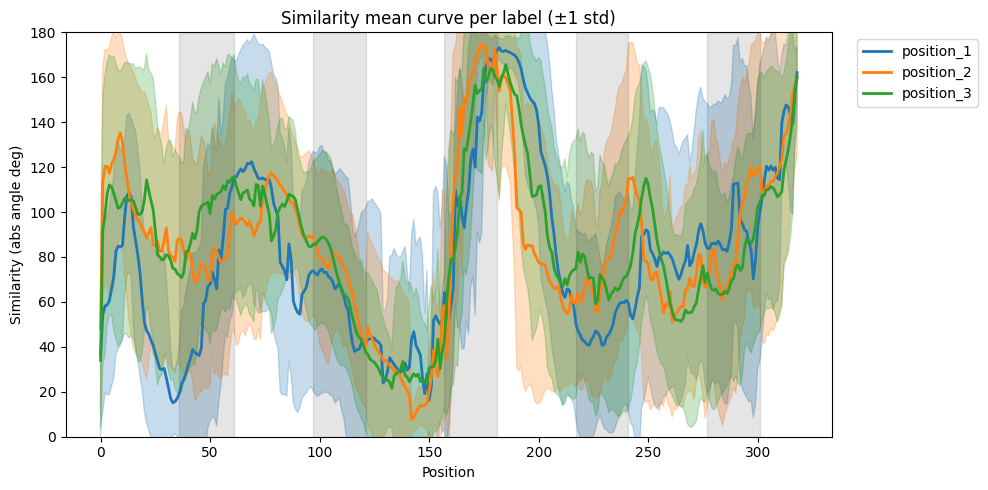

In [833]:
calc_similarity_to_reward_of_track2(data, params, ana_tt=['position*'], ana_bt=['correct'], window_size=51, order=2)

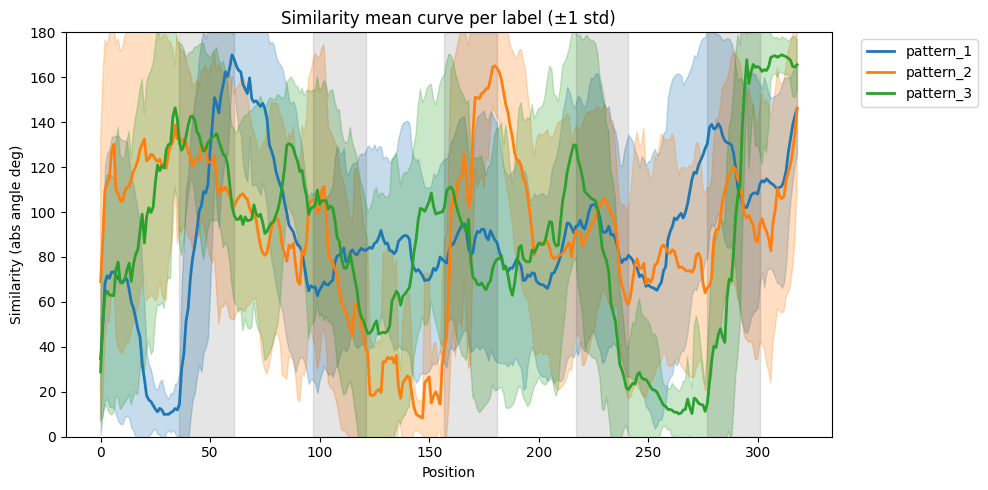

In [834]:
calc_similarity_to_reward_of_track2(data, params, ana_tt=['pattern*'], ana_bt=['correct'], window_size=51, order=2)